## Importing Libraries

In [38]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libraries to help with data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.stats.distributions import chi2

In [2]:
#Reading Data 

df = pd.read_csv('one_bu_test_train_dataset.csv')
df['monthly_date'] = pd.to_datetime(df['monthly_date'])
df.head()

,product_id,Business Unit,Business Group,Major Product Group,Product Group,lineage,monthly_date,month,avg_map_discount,discount_avg,price,days_discount,days_map_discount,sell_in_qty,requested_qty,discount_max,max_map_discount
0,534,2,9052,E43,3199,7131,2020-04-01,4,0.0,0.0,66.86793,0.0,0.0,417.000000,507.000000,0.0,0.0
1,534,2,9052,E43,3199,7131,2019-12-01,12,0.0,0.0,66.86793,0.0,0.0,87.000000,87.000000,0.0,0.0
2,534,2,9052,E43,3199,7131,2020-02-01,2,0.0,0.0,66.86793,0.0,0.0,12.428571,27.857143,0.0,0.0
3,534,2,9052,E43,3199,7131,2020-03-01,3,0.0,0.0,66.86793,0.0,0.0,78.000000,102.000000,0.0,0.0
4,534,2,9052,E43,3199,7131,2019-11-01,11,0.0,0.0,66.86793,0.0,0.0,19.714286,23.142857,0.0,0.0


In [3]:
#Product group wise analysis
prod_group_df = pd.DataFrame(df.groupby(['Product Group','monthly_date']).sum())[['requested_qty']]
prod_group_df.reset_index(inplace=True)
print(prod_group_df.shape)
prod_group_df['prod_group'] = 'P' + prod_group_df['Product Group'].astype(str)
prod_group_df.head()

(477, 3)


,Product Group,monthly_date,requested_qty,prod_group
0,3108,2017-12-01,4.285714,P3108
1,3108,2018-01-01,267.428571,P3108
2,3108,2018-02-01,640.285714,P3108
3,3108,2018-03-01,186.000000,P3108
4,3182,2017-12-01,115.428571,P3182


In [4]:
prod_df = prod_group_df.pivot_table(index='monthly_date',columns=['prod_group'],values='requested_qty')
print(prod_df.shape)
prod_df.head()

(32, 16)


prod_group,P3108,P3182,P3183,P3184,P3185,P3186,P3187,P3188,P3190,P3192,P3199,P5849,P7745,P7746,P7756,P7757
monthly_date,,,,,,,,,,,,,,,,
2017-12-01,4.285714,115.428571,26.428571,331.142857,1126.857143,404.000000,1768.714286,58.428571,625.714286,1580.571429,NaN,34.285714,393.714286,268.714286,2.142857,NaN
2018-01-01,267.428571,2476.000000,759.142857,10429.142858,52777.142856,10429.714286,86082.000000,9399.571429,34012.000000,90730.285717,385.714286,893.142857,16299.428571,16396.285714,423.000000,12.0
2018-02-01,640.285714,2553.285715,1052.571429,12265.428572,64646.571430,16635.428569,106426.571427,19292.714289,58887.714286,114115.428567,528.428571,725.142857,20712.571429,25103.142855,1014.428571,21.0
2018-03-01,186.000000,119.285714,510.857143,10920.285715,80462.428566,18606.857143,51941.714286,12505.285714,52734.857143,66789.142859,879.857143,663.428571,20656.285714,21408.714286,643.428571,0.0
2018-04-01,NaN,477.142857,574.428571,16731.714286,63701.857142,10749.142860,56608.285714,4377.285714,41340.285715,77774.571434,939.857143,363.428571,24792.857142,8959.714286,1004.285714,0.0


### Filling missing values

In [5]:
# we can use either forward filling or back filling for handling missing values. Note that this could also be
# mean/median/mode and more knowledge about followed best practices is required to choose one or the other


## Time Series Analysis

In [ ]:
# we are running the analysis for 1 product at a time. We select a random Product group 3185

In [21]:
prod_P3185 = prod_df['P3185'].to_frame()
prod_P3185 = prod_P3185.head(30)
prod_P3185.head()

,P3185
monthly_date,
2017-12-01,1126.857143
2018-01-01,52777.142856
2018-02-01,64646.571430
2018-03-01,80462.428566
2018-04-01,63701.857142


### Stationarity

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the Time Series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [10]:
sts.adfuller(prod_P3185.P3185)

(-2.842003467001444,
 0.0525198322388889,
 1,
 30,
 {'1%': -3.6699197407407405,
  '5%': -2.9640707407407407,
  '10%': -2.621171111111111},
 486.83345646763627)

For 10% significance we see that our TS P3185 requested quantity has t-statistic less than 10% critical value and p-value is significant indicating stationarity.

*NOTE If the time series is not stationary then we could apply the differencing factor on the records and see if the graph of the time series is a stationary overtime period, not required in this case

### Seasonality

Decomposing time series into 3 parts - 
1. trend (pattern)
2. seasonal (cyclical effects)
3. residual (error of prediction, actual Vs predicted)

Simplest way is Naive Decomposition where expect linear relationship between 3 parts and Time series

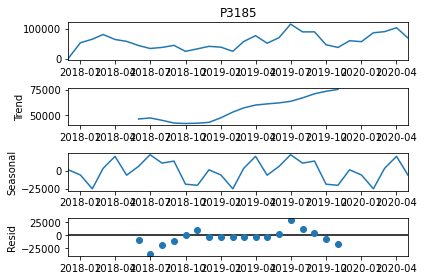

<Figure size 1800x1224 with 0 Axes>

In [25]:
s_dec_multiplicative = seasonal_decompose(prod_P3185.P3185, model = "additive")
s_dec_multiplicative.plot()
plt.figure(figsize=(25,17))
plt.show()

From the above output, we can see clear seasonal effects on requested qty

### ACF Auto Correlation factor : The correlation between sequence and itself

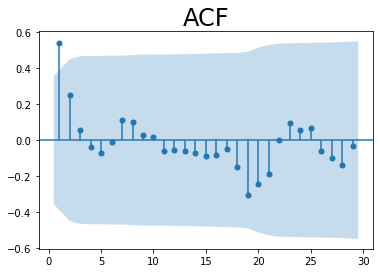

In [28]:
sgt.plot_acf(prod_P3185.P3185, lags = 29, zero = False)
plt.title("ACF", size = 24)
plt.show()

From the ACF plot we establish values only from 1 period lag serve as decent estimator for next period. Rest of the lag periods values are not significant

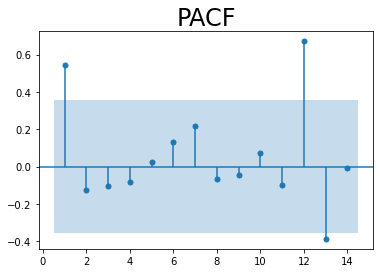

In [30]:
sgt.plot_pacf(prod_P3185.P3185, lags = 14, zero = False, method = ('ols'))
plt.title("PACF", size = 24)
plt.show()

Interesting to see first lag and 12th lag has significant values

# Most appropriate model?

Using the results from ACF and PACF plots, we try to find the simplest model with significant coefficients. we will do log-likelihood ratio test to differenciate between 2 models which is better (lower AIC, BIC)

**Auto Regressive models works best with Stationary TS, so we begin testing with them

## AR(1) Model

In [32]:
model_ar = ARMA(prod_P3185.P3185, order=(1,0))

/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr

In [33]:
results_ar = model_ar.fit()

In [34]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  P3185   No. Observations:                   30
Model:                     ARMA(1, 0)   Log Likelihood                -340.451
Method:                       css-mle   S.D. of innovations          20354.689
Date:                Mon, 31 Jan 2022   AIC                            686.902
Time:                        05:01:10   BIC                            691.106
Sample:                    12-01-2017   HQIC                           688.247
                         - 05-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.532e+04   9590.616      5.768      0.000    3.65e+04    7.41e+04
ar.L1.P3185     0.6282      0.154      4.072      0.000       0.326       0.931
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5917           +0.0000j            1.5917            0.0000
-----------------------------------------------------------------------------
"""

### Interpretation :
Both const and ar.L1.P3185 coefficients have p-value 0. Meaning they are significant. We can try fitting complex model to see if it improves fit (do note we don't want to overfit our model)

## Higher-Lag AR Models

In [35]:
model_ar_2 = ARMA(prod_P3185.P3185, order=(2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  P3185   No. Observations:                   30
Model:                     ARMA(2, 0)   Log Likelihood                -340.157
Method:                       css-mle   S.D. of innovations          20137.394
Date:                Mon, 31 Jan 2022   AIC                            688.315
Time:                        05:06:11   BIC                            693.919
Sample:                    12-01-2017   HQIC                           690.108
                         - 05-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.536e+04   8344.844      6.634      0.000     3.9e+04    7.17e+04
ar.L1.P3185     0.7325      0.205      3.579      0.000       0.331       1.134
ar.L2.P3185    -0.1652      0.214     -0.772      0.440      -0.584       0.254
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2176           -1.0665j            2.4607           -0.0713
AR.2            2.2176           +1.0665j            2.4607            0.0713
-----------------------------------------------------------------------------
"""

## LLR Test

In [39]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [40]:
LLR_test(model_ar, model_ar_2)

0.443

The LLR suggest the more complex model AR2 is not significant, which we also observed in coefficients p-value. So we stick with simpler AR(1) model which was also suggested in ACF and PACF plots. Not trying more complex AR models

## MA(1) Model

In [41]:
model_ma_1 = ARMA(prod_P3185.P3185[1:], order=(0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  P3185   No. Observations:                   29
Model:                     ARMA(0, 1)   Log Likelihood                -326.819
Method:                       css-mle   S.D. of innovations          18816.320
Date:                Mon, 31 Jan 2022   AIC                            659.638
Time:                        05:41:20   BIC                            663.739
Sample:                    01-01-2018   HQIC                           660.922
                         - 05-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.936e+04   5572.274     10.653      0.000    4.84e+04    7.03e+04
ma.L1.P3185     0.6151      0.150      4.089      0.000       0.320       0.910
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.6259           +0.0000j            1.6259            0.5000
-----------------------------------------------------------------------------
"""

### Interpretation :
Both const and ar.L1.P3185 coefficients have p-value 0. Meaning they are significant. We can try fitting complex model to see if it improves fit (do note we don't want to overfit our model)

*Note AIC and BIC are slightly lower than AR(1) model

## Higher-Lag MA Models

In [42]:
model_ma_2 = ARMA(prod_P3185.P3185[1:], order=(0,2))
results_ma_2 = model_ma_2.fit()
print(results_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ma_1, model_ma_2)))

                              ARMA Model Results                              
Dep. Variable:                  P3185   No. Observations:                   29
Model:                     ARMA(0, 2)   Log Likelihood                -326.138
Method:                       css-mle   S.D. of innovations          18391.765
Date:                Mon, 31 Jan 2022   AIC                            660.276
Time:                        05:44:48   BIC                            665.745
Sample:                    01-01-2018   HQIC                           661.989
                         - 05-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.903e+04   6294.355      9.378      0.000    4.67e+04    7.14e+04
ma.L1.P3185     0.6524      0.175      3.720      0.000       0.309       0.996
ma.L2.P3185     0.2257      0.179      1.264    

/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr

The LLR suggest the more complex model MA2 is not significant, which we also observed in coefficients p-value. So we stick with simpler MA(1) model which was also suggested in ACF and PACF plots. Not trying more complex MA models

## ARMA(1) Model

In [47]:
model_ar_1_ma_1 = ARMA(prod_P3185.P3185[1:], order=(1,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()
print("\nLLR test p-value AR(1) and ARMA(1) = " + str(LLR_test(model_ar, model_ar_1_ma_1)))
print("\nLLR test p-value MA(1) and ARMA(1) = " + str(LLR_test(model_ma_1, model_ar_1_ma_1)))

/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr


LLR test p-value AR(1) and ARMA(1) = 0.0

LLR test p-value MA(1) and ARMA(1) = 0.131


We see from the LLR test, MA(1) model is better over ARMA(1) model. p-value at 5% or 10% is not significant. however close to 10%. We would also like to check this for other Product Groups and see if it holds true for all

# From above experiments we decide MA(1) to be most appropriate model
* Note we can run results on higher level Major product group but their are trade-offs. Going to higher level dilutes the information of product groups. Significant quantity ordered differences between products of same Major product group

In [ ]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr

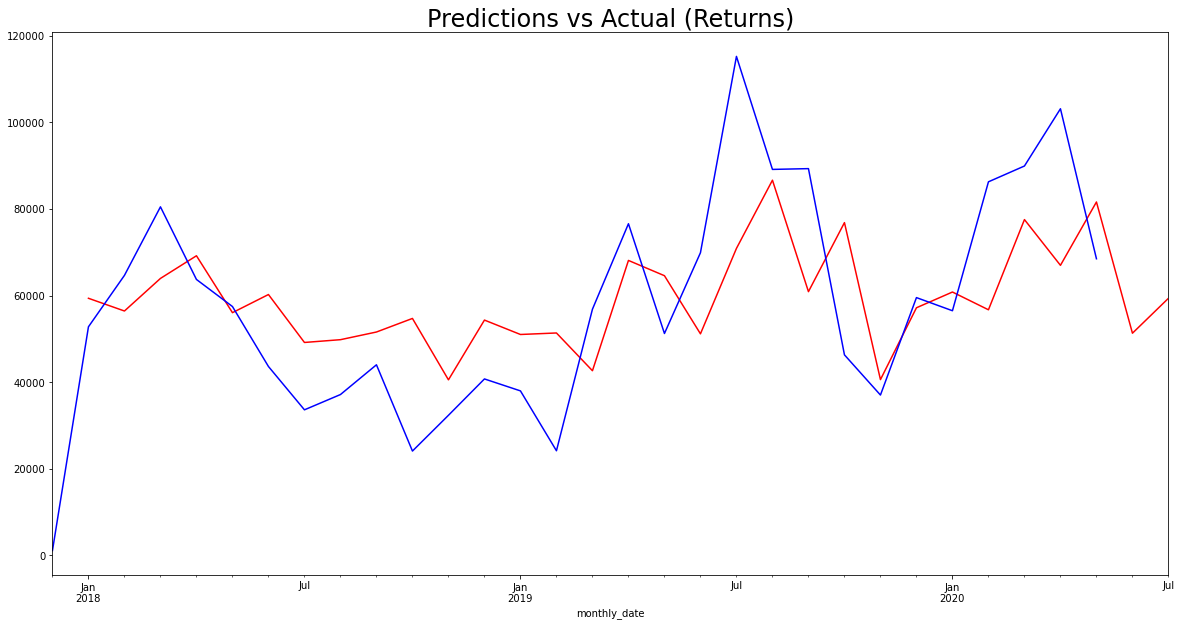

In [54]:
model_ma_1 = ARMA(prod_P3185.P3185[1:], order=(0,1))
results_ma_1 = model_ma_1.fit()

start_date = '2018-01-01'
end_date = '2020-07-01'

df_pred_ma = results_ma_1.predict(start = '2018-01-01', end = '2020-07-01')
df_pred_ma[start_date:end_date].plot(figsize = (20,10), color = "red") 
prod_P3185.P3185.plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [66]:
df_pred_P3185 = df_pred_ma.head(32).to_frame()
df_pred_P3185 = df_pred_P3185.reset_index()
df_pred_P3185 = df_pred_P3185.rename(columns={'index': 'monthly_date', 0: 'requested_qty_predicted'})
df_pred_P3185.tail()

,monthly_date,requested_qty_predicted
26,2020-03-01,77524.469817
27,2020-04-01,66962.784978
28,2020-05-01,81585.359309
29,2020-06-01,51297.465350
30,2020-07-01,59358.963868


# Next Steps

1. Discuss with the team/client if the levels of analysis is appropriate
2. Discuss the approach with a Principal DS or DS Manager and incorporate feedbacks
3. Also take into consideration how other variables can be incorporated and if they are adding any value. We checked in EDA all other variables don't influence requested qty or sell in qty
4. If everything checks out, loop the Product Groups 1 by 1 to predict the requested qty and get the final results
5. For the 7% product groups that don't have 2+ years of data for forecasting, consult with (2) what is the best approach. A simple moving average of last Quarters might be an option

In [67]:
!jupyter nbconvert --to html Code2_Forecasting.ipynb

[NbConvertApp] Converting notebook Code2_Forecasting.ipynb to html
